# Plotting psychometric curves

This notebook contains examples of fitting and plotting psychometric data for both training and biased sessions using ONE.  It also demonstrates how to fetch and plot the fitted parameters using DataJoint.

The module for fitting psychometric data is called 'psychofit' and is avaliable in both Python and MATLAB.  The python module complete with examples can be found [here](https://github.com/cortex-lab/psychofit), however there is also a copy in [ibl-pipeline](https://github.com/int-brain-lab/IBL-pipeline/blob/master/ibl_pipeline/utils/psychofit.py).

In order to run these examples you must how ibl_pipline and ibllib on your path.

In [34]:
%matplotlib notebook

from datetime import datetime  # Only for formating title

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from oneibl.one import ONE
import sys

sys.path.extend(['C:\\Users\\User\\Documents\\Github\\IBL_pipeline', 'C:/Users/User/Documents/Github/IBL_pipeline'])

import ibl_pipeline.utils.psychofit as psy
from ibl_pipeline import behavior, acquisition, subject
from ibl_pipeline.analyses.behavior import PsychResultsBlock, PsychResults

one = ONE()

def makepretty():
    """A simple function to format our psychometric plots"""
    # Ensure x label is not cut off
    plt.gcf().subplots_adjust(bottom=0.15)
    # Plot lines at zero and .5
    plt.plot((0, 0), (0, 1), 'k:')
    plt.plot((-100, 100), (.5, .5), 'k:')
    # Set limits and labels
    plt.gca().set(ylim=[-.05, 1.05], xlabel='contrast (%)', ylabel='proportion rightward')
    sns.despine(offset=10, trim=True)

Connected to https://alyx.internationalbrainlab.org as miles


## Using ONE
### Plotting an unbiased training session

In [35]:
# Find a training session with good performance
eids = one.search(task_protocol='training', performance_gte=70, dataset_types='trials.intervals')  #, limit=1  # waay slow
eid = eids[50]
trials = one.load_object(eid, 'trials')  # Download the trials ALF object

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4697/4697 [00:22<00:00, 205.18it/s]


In [36]:
# Wrangle the data into the correct form
def signed_contrast(trials):
    """Returns an array of signed contrasts in percent, where -ve values are on the left"""
    # Replace NaNs with zeros, stack and take the difference
    contrast = np.nan_to_num(np.c_[trials.contrastLeft, trials.contrastRight])
    return np.diff(contrast).flatten() * 100

contrast = signed_contrast(trials)

In [37]:
# Remove no-go trials (optional)
nogo = trials.choice == 0
contrast = contrast[~nogo]
trials.choice = trials.choice[~nogo]

# Get the contrast set and the number of trials per contrast
xx, nn = np.unique(contrast, return_counts=True)
rightward = trials.choice == -1
# Calculate the proportion rightward for each contrast type
pp = np.vectorize(lambda x: np.mean(rightward[x == contrast]))(xx)

<IPython.core.display.Javascript object>


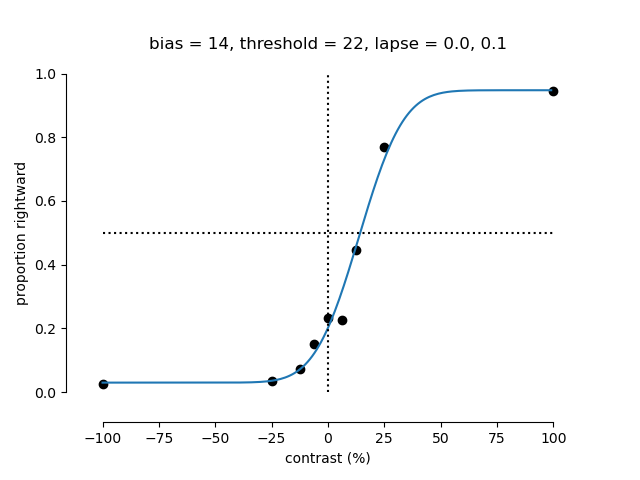

In [38]:
# Fit the data using least squares
# For more information on these functions please look at the docstring
#   help(psy.mle_fit_psycho)     # The fitting function
#   help(psy.erf_psycho_2gammas) # The function to fit to

# data: 3 x n matrix where first row corrsponds to stim levels (%), 
# the second to number of trials for each stim level (int),
# the third to proportion correct (float between 0 and 1)
data = np.vstack((xx, nn, pp))
kwargs = {
    # parmin: The minimum allowable parameter values, in the form
    # [bias, threshold, lapse_low, lapse_high]
    'parmin': np.array([-25., 10., 0., 0.]),
    # parmax: The maximum allowable parameter values
    'parmax': np.array([25, 50., .2, .2]),
    # parstart: The starting parameters
    # (choose ones close to where you think the true values are)
    'parstart': np.array([0., 40., .1, .1]),
    # nfits: The number of fits to run
    'nfits': 10
}

# Fit the parameters for the erf function with 2 seperate lapses
pars, L = psy.mle_fit_psycho(data, 'erf_psycho_2gammas', **kwargs);

# graphics
plt.figure()
x = np.arange(-100, 100)  # The x-axis values for our curve
y = psy.erf_psycho_2gammas(pars, x)  # The y-axis values
plt.plot(xx, pp, 'ko', mfc='k')  # Plot the contrast values
plt.plot(x, y)  # Our psychometric curve
plt.title('bias = {:2.0f}, threshold = {:2.0f}, lapse = {:.01f}, {:.01f}'.format(*pars))
makepretty()

### Plotting a biased session

In [39]:
# Find a training session with good performance
eids = one.search(task_protocol='ephys', performance_gte=70, dataset_types='trials.intervals')
eid = eids[5]
trials = one.load_object(eid, 'trials')
trials.probabilityLeft, = one.load(eid, 'trials.probabilityLeft')  # FIXME load_object bug
contrast = signed_contrast(trials)  # Function defined in previous section

# data: a dict whose keys are the block type and values a
# 3 x n matrix where first row corrsponds to stim levels (%), 
# the second to number of trials for each stim level (int),
# the third to proportion correct (float between 0 and 1)
data = {}
for pL in np.unique(trials.probabilityLeft):
    in_block = trials.probabilityLeft == pL
    xx, nn = np.unique(contrast[in_block], return_counts=True)
    rightward = trials.choice == -1
    pp = np.vectorize(lambda x: np.mean(rightward[(x == contrast) & in_block]))(xx)
    data[pL] = np.vstack((xx, nn, pp))

<IPython.core.display.Javascript object>


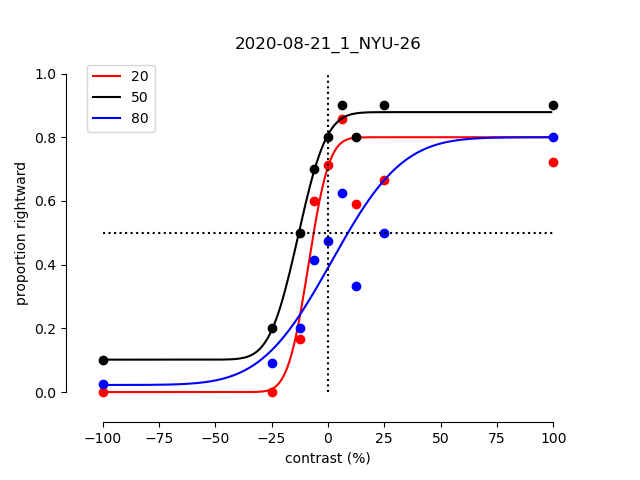

prob left = 0.2, bias = -9, threshold = 10, lapse = 0.0, 0.2
prob left = 0.5, bias = -13, threshold = 14, lapse = 0.1, 0.1
prob left = 0.8, bias =  2, threshold = 35, lapse = 0.0, 0.2


In [40]:
# A colour map for the block type
colours = dict(zip(data.keys(), ('r', 'k', 'b')))

# Increase bias bounds (kwargs defined in previous section)
kwargs['parmin'][0] = -50.
kwargs['parmax'][0] = 50.

plt.figure()
# For each block type, fit the data separately and plot
for pL, da in data.items():
    # Fit it
    pars, L = psy.mle_fit_psycho(da, 'erf_psycho_2gammas', **kwargs);
    # Print pars
    print('prob left = {:.1f}, bias = {:2.0f}, threshold = {:2.0f}, lapse = {:.01f}, {:.01f}'.format(pL, *pars))

    # graphics
    x = np.arange(-100, 100)  # The x-axis values for our curve
    plt.plot(da[0,:], da[2,:], colours[pL] + 'o')
    plt.plot(x, psy.erf_psycho_2gammas(pars, x), label=f'{int(pL*100)}', color=colours[pL])

# Get some details for the title
det = one.get_details(eid)
ref = f"{datetime.fromisoformat(det['start_time']).date()}_{det['number']:d}_{det['subject']}"

plt.title(ref)
plt.legend()
makepretty()

## Using DataJoint
### Plotting an unbiased training session

In [41]:
# Pick a random training session with good performance
sessions = acquisition.Session & 'task_protocol LIKE "%training%"' & behavior.CompleteTrialSession
query = (PsychResults  & 'performance > 0.7') * sessions.proj('session_uuid')

# Fetch the data
fields = ('signed_contrasts', 'n_trials_stim_right', 'prob_choose_right', 'bias', 'threshold', 'lapse_low', 'lapse_high')
blob = query.fetch(*fields, limit=1, squeeze=True)  # Fetch first in list
xx, nn, pp, (*pars) = [v[0] for v in blob]  # Unpack data into variables
pars = np.array(pars)

<IPython.core.display.Javascript object>


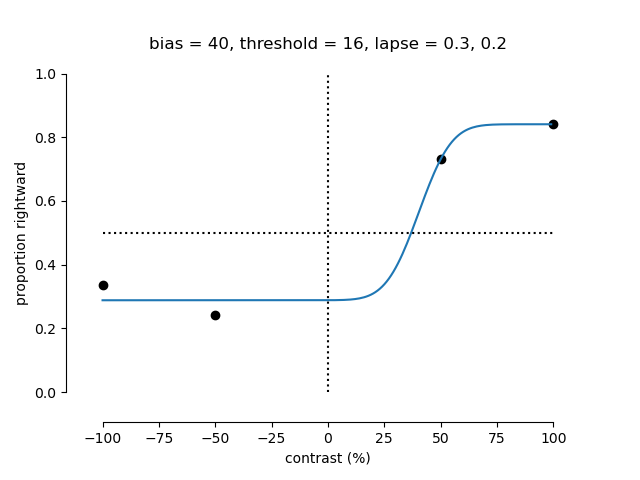

In [42]:
# Plot the data
plt.figure()
plt.plot(xx * 100, pp, 'ko', mfc='k')  # Plot the contrast values
x = np.arange(-100, 100)  # The x-axis values for our curve
plt.plot(x, psy.erf_psycho_2gammas(pars, x))  # Plot our curve

plt.title('bias = {:2.0f}, threshold = {:2.0f}, lapse = {:.01f}, {:.01f}'.format(*pars))
makepretty()

### Plotting a biased session

In [43]:
# Pick a random ephys session with good performance
sessions = acquisition.Session & 'task_protocol LIKE "%ephys%"' & behavior.CompleteTrialSession
*_, uuid = (PsychResults * sessions & 'performance > 0.7').proj('session_uuid').head(1)[0]

# Fetch data from the PsychResultsBlock table
query = PsychResultsBlock * acquisition.Session.proj('session_uuid') & {'session_uuid': uuid}
blocks = query.fetch('prob_left', *fields)

<IPython.core.display.Javascript object>


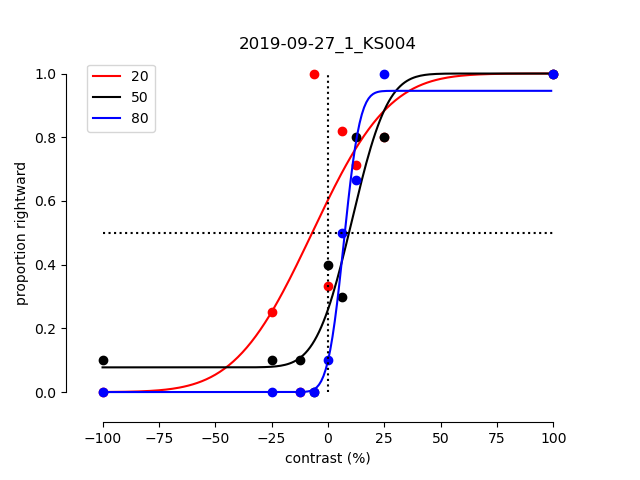

prob left = 0.2, bias = -7, threshold = 38, lapse = 0.0, 0.0
prob left = 0.5, bias = 11, threshold = 18, lapse = 0.1, 0.0
prob left = 0.8, bias =  7, threshold =  8, lapse = 0.0, 0.1


In [44]:
plt.figure()
# For each block type, plot the data
for pL, xx, nn, pp, (*pars) in zip(*blocks):
    # Print pars
    print('prob left = {:.1f}, bias = {:2.0f}, threshold = {:2.0f}, lapse = {:.01f}, {:.01f}'.format(pL, *pars))
    # Plot contrast values
    plt.plot(xx * 100, pp, colours[pL] + 'o')  # colours map defined in above section
    x = np.arange(-100, 100)  # The x-axis values for our curve
    plt.plot(x, psy.erf_psycho_2gammas(pars, x), label=f'{int(pL*100)}', color=colours[pL])
    
# Get some details for the title
query = (acquisition.Session & {'session_uuid': uuid}) * subject.Subject
start_time, number, nickname = query.fetch1('session_start_time', 'session_number', 'subject_nickname')

plt.title(f'{start_time.date()}_{number}_{nickname}')
plt.legend()
makepretty()